# VAL AND MOM IN THE SAME PLACE

[@sparshsah](https://github.com/sparshsah)

## Empirical Background: Value and Momentum Everywhere

["Value and Momentum Everywhere" (Asness-Moskowitz-Pedersen 2013)](https://www.aqr.com/Insights/Research/Journal-Article/Value-and-Momentum-Everywhere) was a seminal contribution to liquid-alternative relative-value factor investing, in both single-name and macro securities.

The following cross-sectional pricing anomalies (based on backward-looking observed returns) tend to stand up across geographies (e.g. emerging vs G10 vs currencies), asset classes (e.g. commodities vs government bonds), and time:
* Sign of spread return over `[0, -1 month]` reverses
* Sign of spread return over `[-2 months, -12 months]` continues
* Sign of spread return over `[-2 years, -5 years]` reverses

(Cliff himself often chides asset allocators for being "momentum investors at a value horizon", i.e. pulling money from underperforming managers and plowing it into outperforming managers based on trailing 3-year returns.)

Separately, the following directional (timeseries) pricing anomalies:
* Sign of own return over `[0, -1 week]` reverses
* Sign of own return over `[-2 weeks, -52 weeks]` continues
* Sign of own return over `[-2 years, -5 years]` reverses

## How is This Possible?

It initially blew my mind that these effects could coexist. Short-term returns reverse, but medium-term returns continue... isn't the medium term made up of just a bunch of short terms?? But here's a simple example:

In [135]:
FAST_HZN: Final[int] = 21  # a trading month
SLOW_HZN: Final[int] = 261  # a trading year
T: Final[int] = 100_000

np.random.seed(42)
x = pd.Series(np.random.normal(size=T))
# make standardized timeseries momentum signals
fast_sig = _make_std_tsmom_sig(x=x, front_end=0, back_end=FAST_HZN)
slow_sig = _make_std_tsmom_sig(x=x, front_end=FAST_HZN, back_end=SLOW_HZN)
sig = (-fast_sig + +slow_sig) / 2**0.5
r = sig.shift() * 0.01
# this should be about 16% annualized vol
r.std() * 261**0.5

0.16327831120450118

In [136]:
# yep, the correlations check out
r.corr(
    r.rolling(FAST_HZN).sum().shift()
)

0.7259139766628292

In [137]:
r.corr(
    r.rolling(SLOW_HZN - FAST_HZN).sum().shift(FAST_HZN).shift()
)

0.12193145569903407

<AxesSubplot:>

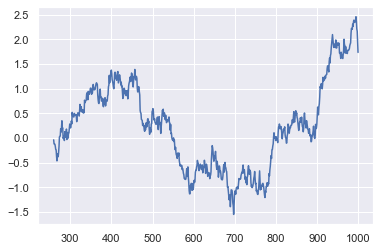

In [127]:
slow_sig.plot()

<AxesSubplot:>

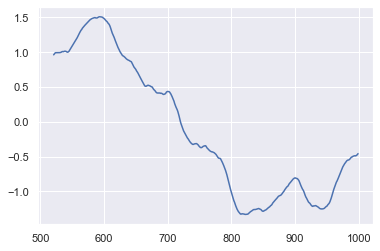

In [130]:
r.rolling(SLOW_HZN - FAST_HZN).sum().shift(FAST_HZN).plot()

In [125]:
r.corr(
    r.rolling(SLOW_HZN - FAST_HZN).sum().shift(FAST_HZN).shift()
)

-0.13387664769056323

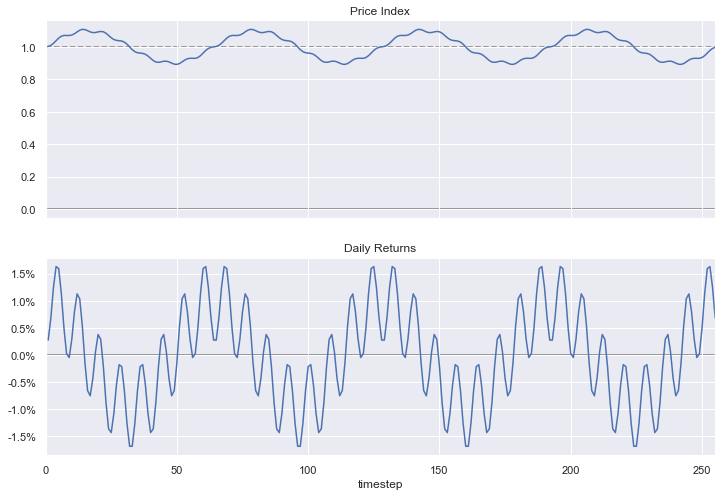

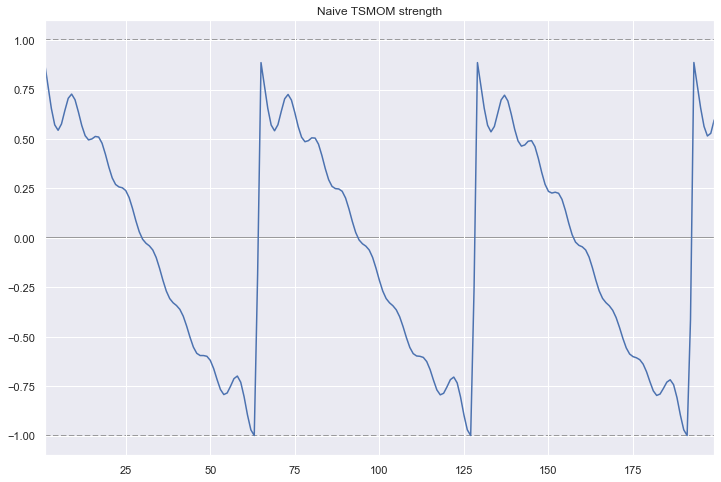

<AxesSubplot:title={'center':'Naive TSMOM strength'}, xlabel='hzn'>

## Theoretical Question: What's the Story?

I propose a behavioral story that is (a) self-consistent and (b) at least first-order consistent with stylized facts about market microstructure that could give rise to this effect.

## Appendix: imports

In [95]:
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from foggy_statslib import core as fc

In [91]:
def _get_wave(
    a: float = 1,
    period: float = 4,
    sz: int = 256,
) -> pd.Series:
    b = 2 * np.pi / period
    domain = pd.Series(range(sz))
    wave = a * pd.Series(np.sin(b * domain))
    return wave

def _get_one_corr(r: pd.Series, hzn: int = 1) -> float:
    """TSMOM evaluation e.g. Today's return vs Last month's return."""
    r_cum_lagged = r.rolling(window=hzn).sum().shift()
    return r.corr(r_cum_lagged)

def _get_all_corrs(r: pd.Series) -> pd.Series:
    corrs = pd.Series(
        {
            hzn:
            _get_one_corr(r=r, hzn=hzn)
            for hzn in range(1, 200)
        }
    ).rename_axis(index="hzn")
    return corrs

In [106]:
def _make_std_tsmom_sig(
    x: pd.Series,
    front_end: int = 0,
    back_end: int = 65,
) -> pd.Series:
    wdw = back_end - front_end
    sig = x.rolling(window=wdw).sum()
    # catch up
    sig = sig.shift(front_end)
    # standardize
    sig = sig / wdw**0.5
    return sig

<AxesSubplot:>

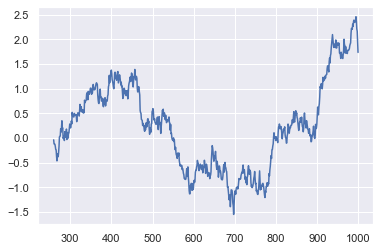

In [131]:
slow_sig.plot()